# Unmasking Image Tempering: An SVD Approachols

## 1. Prepare and Preprocess Images: We will Use authentic and tampered images for analysis

### Importing required tools

In [1]:
import os
import cv2
import numpy as np
import random

from PIL import Image

from scipy.stats import entropy
from skimage.util import view_as_blocks

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, ConcatDataset, Dataset
import matplotlib.pyplot as plt

### Assign the filepath for the dataset

In [2]:
authentic_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au'
tempered_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'

### Function to load a fixed number of images from a directory


In [3]:
def load_images(path, num_samples=300, size=(256, 256)):
    images = []
    filenames = os.listdir(path)
    random.shuffle(filenames)
    for file in filenames[:num_samples]:
        img_path = os.path.join(path, file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            images.append(img)
    return images

### Load 300 samples each


In [4]:
authentic_images = load_images(authentic_path, num_samples=300)
tempered_images = load_images(tempered_path, num_samples=300)

print(f"Loaded {len(authentic_images)} authentic and {len(tempered_images)} tampered images.")

Loaded 300 authentic and 300 tampered images.


### Function to visualize a grid of images


In [5]:
def visualize_images(images, title, num_images=6):
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        plt.title(f"{title} Image {i+1}")
    plt.suptitle(f"{title} Images", fontsize=16)
    plt.tight_layout()
    plt.show()

### Visualize a few authentic and tampered images


Visualizing authentic images:


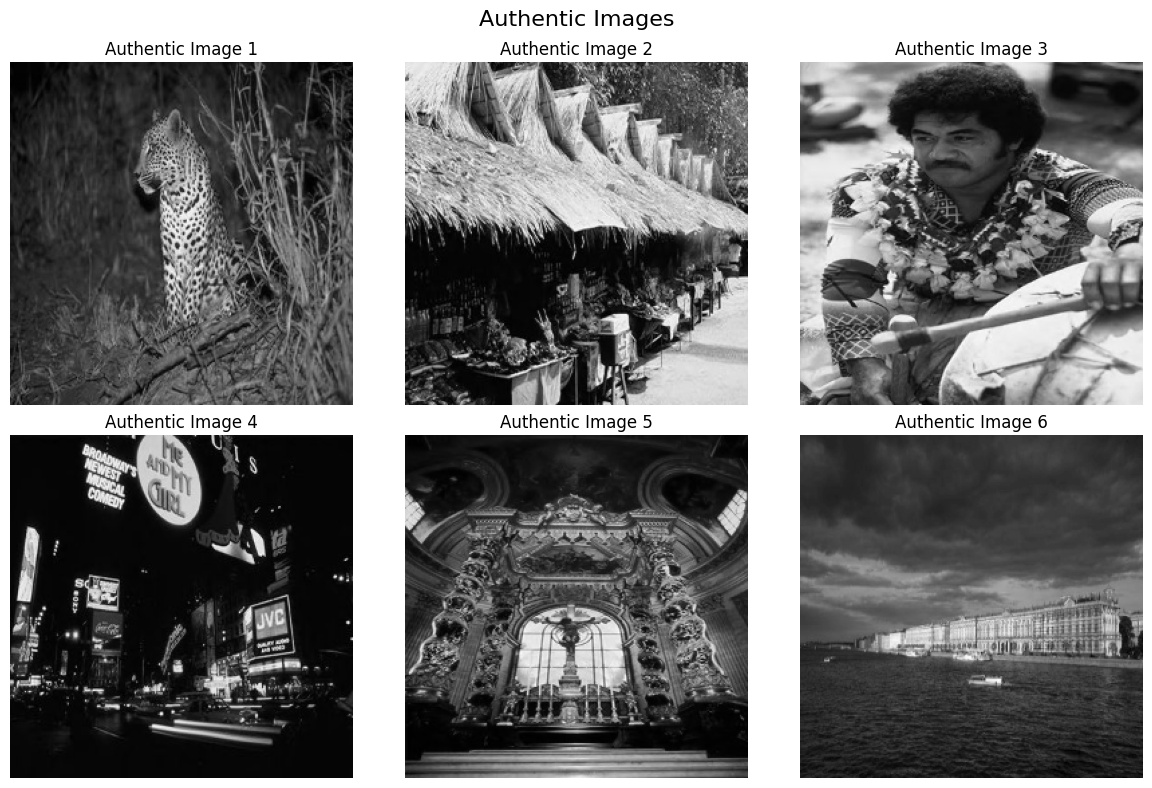

In [6]:
print("Visualizing authentic images:")
visualize_images(authentic_images, "Authentic")

Visualizing tampered images:


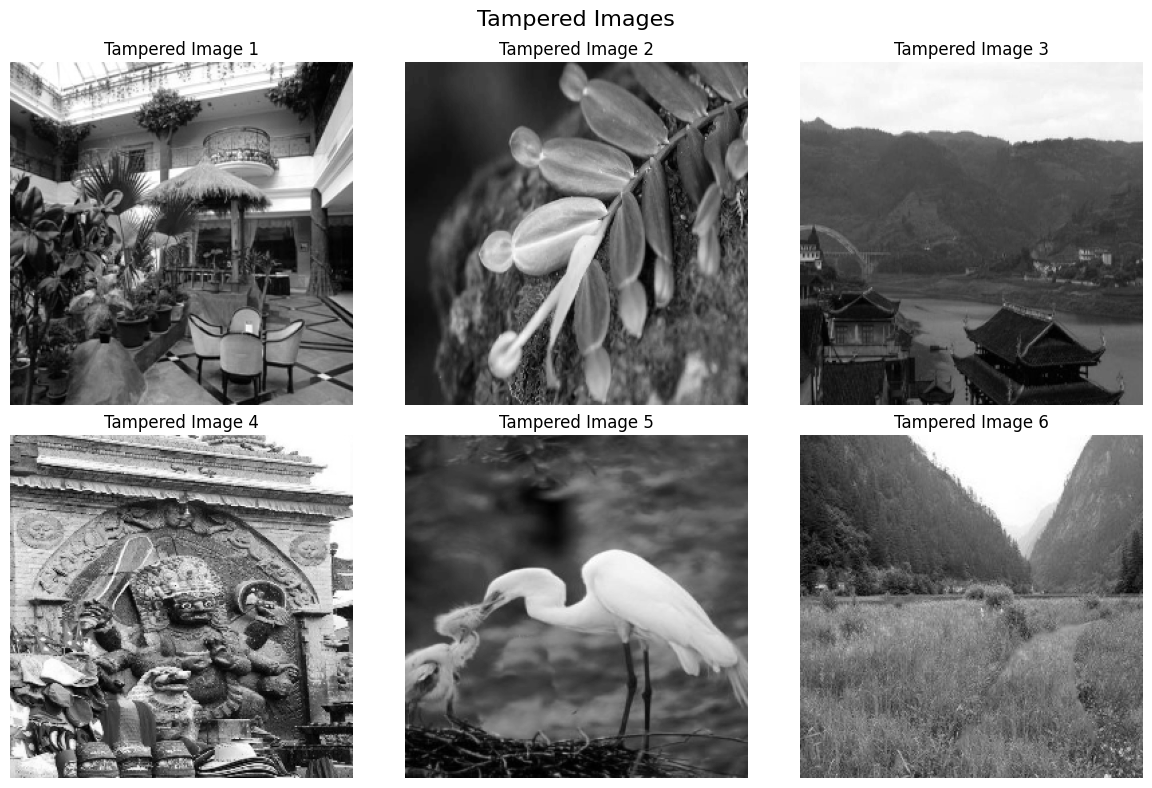

In [7]:
print("Visualizing tampered images:")
visualize_images(tempered_images, "Tampered")

## 2 Apply SVD to Decompose each image and Extract Features to analyze change in Singular Values:

### Function to compute energy ratio


In [8]:
def compute_energy_ratio(singular_values, k):
    return np.sum(singular_values[:k]) / np.sum(singular_values)

### Function to compute singular value entropy

In [9]:

def compute_singular_value_entropy(singular_values, k):
    normalized_sv = singular_values[:k] / np.sum(singular_values[:k])
    return entropy(normalized_sv)

### Analyze singular values for top-k and compute statistical metrics


In [10]:
def analyze_singular_values(image_list, k=40):
    metrics = []
    sv_decay = []

    for img in image_list:
        # Compute SVD
        U, S, V = np.linalg.svd(img, full_matrices=False)
        sv_decay.append(S)  # Store full singular values for decay plot

        # Select top-k singular values
        top_k_sv = S[:k]

        # Compute statistical metrics
        mean = np.mean(top_k_sv)
        variance = np.var(top_k_sv)
        energy_ratio = compute_energy_ratio(S, k)
        sv_entropy = compute_singular_value_entropy(S, k)

        metrics.append({
            'mean': mean,
            'variance': variance,
            'energy_ratio': energy_ratio,
            'sv_entropy': sv_entropy,
        })

    return metrics, sv_decay

### Compare metrics for authentic and tampered images


In [11]:
k = 40
auth_metrics, auth_sv_decay = analyze_singular_values(authentic_images, k=k)
temp_metrics, temp_sv_decay = analyze_singular_values(tempered_images, k=k)

### Compute averages for comparison


In [12]:
auth_means = np.mean([m['mean'] for m in auth_metrics])
temp_means = np.mean([m['mean'] for m in temp_metrics])
print(f"Authentic Images - Mean: {auth_means:.4f}")
print(f"Tampered Images - Mean: {temp_means:.4f}")

Authentic Images - Mean: 1822.8240
Tampered Images - Mean: 1923.1705


### Compute varieance for comparison


In [13]:
auth_variances = np.mean([m['variance'] for m in auth_metrics])
temp_variances = np.mean([m['variance'] for m in temp_metrics])
print(f"Authentic Images - Variance: {auth_variances:.4f}")
print(f"Tampered Images - Variance: {temp_variances:.4f}")

Authentic Images - Variance: 17974759.5434
Tampered Images - Variance: 22974465.7775


### Compute Energy Ratios for comparison


In [14]:
auth_energy_ratios = np.mean([m['energy_ratio'] for m in auth_metrics])
temp_energy_ratios = np.mean([m['energy_ratio'] for m in temp_metrics])
print(f"Authentic Images - Energy Ratio: {auth_energy_ratios:.4f}")
print(f"Tampered Images - Energy Ratio: {temp_energy_ratios:.4f}")

Authentic Images - Energy Ratio: 0.7372
Tampered Images - Energy Ratio: 0.7408


### Compute Singular Vales for comparison


In [15]:
auth_sv_entropies = np.mean([m['sv_entropy'] for m in auth_metrics])
temp_sv_entropies = np.mean([m['sv_entropy'] for m in temp_metrics])
print(f"Authentic Images - SV Entropy: {auth_sv_entropies:.4f}")
print(f"Tampered Images - SV Entropy: {temp_sv_entropies:.4f}")

Authentic Images - SV Entropy: 2.7938
Tampered Images - SV Entropy: 2.7029


### Function to plot Singular Value Decay Curve


In [16]:
def plot_singular_value_decay(auth_sv, temp_sv, k):
    plt.figure(figsize=(10, 6))
    
    # Plot average decay for authentic images
    auth_avg_decay = np.mean(auth_sv, axis=0)
    temp_avg_decay = np.mean(temp_sv, axis=0)

    plt.plot(auth_avg_decay[:k], label="Authentic", marker="o")
    plt.plot(temp_avg_decay[:k], label="Tampered", marker="x")

    plt.title("Singular Value Decay Curve")
    plt.xlabel(f"Top-{k} Singular Values")
    plt.ylabel("Singular Value Magnitude")
    plt.legend()
    plt.grid(True)
    plt.show()

### Visualize decay curves


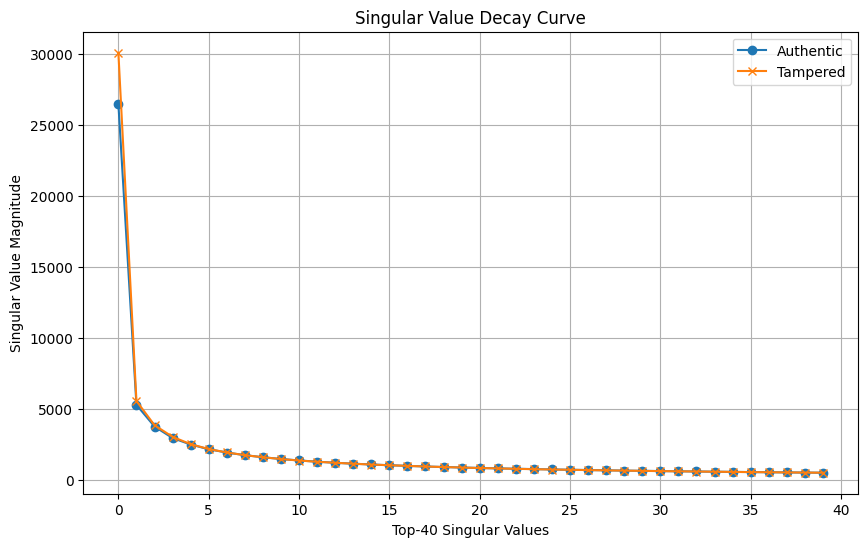

In [17]:
plot_singular_value_decay(auth_sv_decay, temp_sv_decay, k)

## 3 Highlight tampered regions by overlaying heatmaps.

### Function to divide the image into blocks


In [18]:
def divide_into_blocks(image, block_size=(16, 16)):
    """
    Divides the input image into non-overlapping blocks of the given size.
    """
    h, w = image.shape
    bh, bw = block_size
    return view_as_blocks(image, block_size).reshape(-1, bh, bw)

### Function to compute SVD metrics for each block

In [19]:
def compute_block_metrics(blocks, k=5):
    """
    Computes singular value metrics (mean, variance, energy ratio, entropy) for each block.
    """
    metrics = []

    for block in blocks:
        U, S, V = np.linalg.svd(block, full_matrices=False)

        # Select top-k singular values
        top_k_sv = S[:k]

        # Compute metrics
        mean = np.mean(top_k_sv)
        variance = np.var(top_k_sv)
        energy_ratio = compute_energy_ratio(S, k)
        sv_entropy = compute_singular_value_entropy(S, k)

        metrics.append({'mean': mean, 'variance': variance, 'energy_ratio': energy_ratio, 'sv_entropy': sv_entropy})
    
    return metrics

### Function to detect anomalies in blocks


In [20]:
def detect_anomalies(metrics, threshold_factor=2.0):
    """
    Detect blocks with significant deviations from global statistics.
    """
    global_means = np.mean([m['mean'] for m in metrics])
    global_variances = np.mean([m['variance'] for m in metrics])
    global_energy_ratios = np.mean([m['energy_ratio'] for m in metrics])
    global_entropies = np.mean([m['sv_entropy'] for m in metrics])

    anomalies = []
    for idx, m in enumerate(metrics):
        if (
            abs(m['variance'] - global_variances) > threshold_factor * global_variances or
            abs(m['energy_ratio'] - global_energy_ratios) > threshold_factor * global_energy_ratios
        ):
            anomalies.append(idx)
    return anomalies

### Function to visualize anomalies with heatmap


In [21]:
def visualize_heatmap(image, block_size, anomalies, blocks_per_row):
    """
    Overlays a heatmap on the original image to highlight tampered regions.
    """
    heatmap = np.zeros_like(image, dtype=np.float32)
    h, w = image.shape
    bh, bw = block_size

    for idx in anomalies:
        row = idx // blocks_per_row
        col = idx % blocks_per_row
        heatmap[row * bh:(row + 1) * bh, col * bw:(col + 1) * bw] = 1.0

    plt.figure(figsize=(10, 6))
    plt.imshow(image, cmap='gray')
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title("Tampered Region Heatmap")
    plt.axis("off")
    plt.show()

Processing Images...
Visualizing Heatmap for Image 169


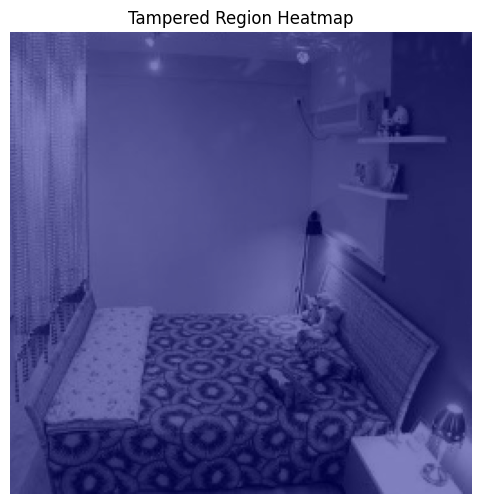

Visualizing Heatmap for Image 113


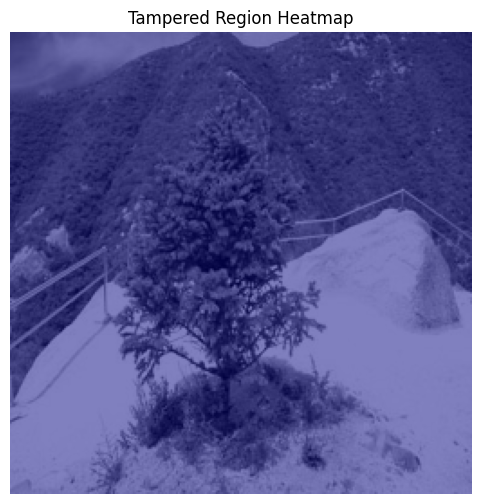

Visualizing Heatmap for Image 97


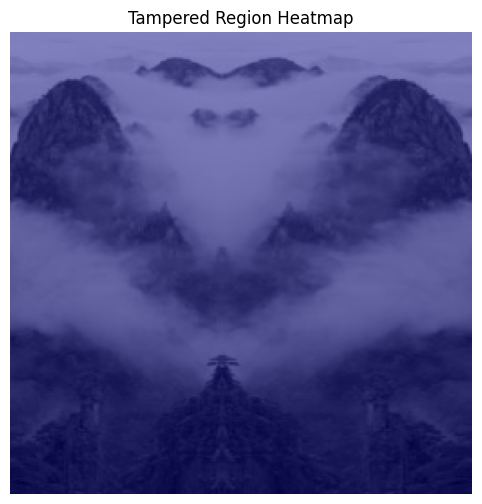

Visualizing Heatmap for Image 153


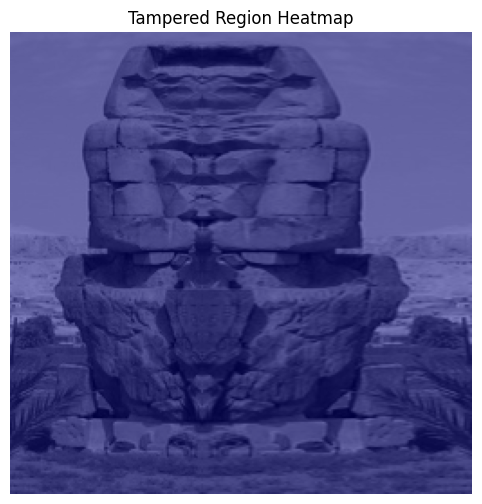

Visualizing Heatmap for Image 244


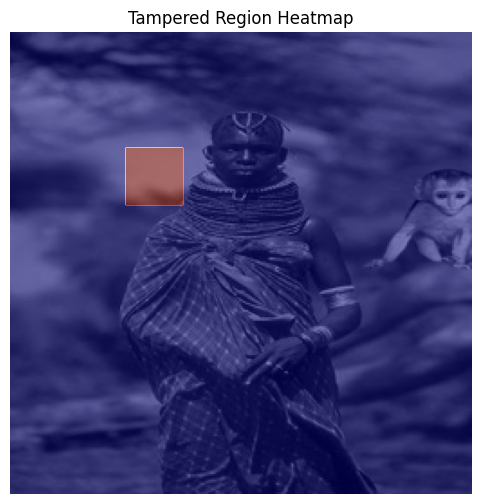

Visualizing Heatmap for Image 132


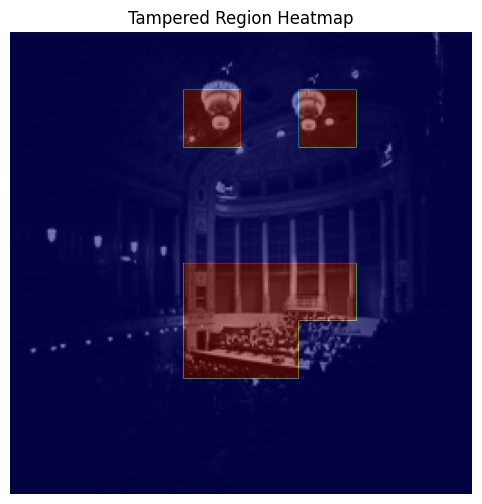

In [22]:
block_size = (32, 32)  # Block size for dividing images
k = 20  # Top-k singular values


num_images_to_plot = 6
print("Processing Images...")
# Process authentic and tempered images
for idx, image_set in enumerate([authentic_images, tempered_images]):
    set_name = "Authentic" if idx == 0 else "Tempered"
    

    # Randomly select 6 images from the set
    selected_indices = random.sample(range(len(image_set)), num_images_to_plot)

    # Get the selected image
    for i in selected_indices:
        image = image_set[i]  

        # Convert to grayscale if not already
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Divide the image into blocks
        image_blocks = divide_into_blocks(image, block_size)

        # Compute metrics for each block
        block_metrics = compute_block_metrics(image_blocks, k)

        # Detect anomalies in metrics
        anomalies = detect_anomalies(block_metrics)

        # Visualize tampered regions for tempered images
        if set_name == "Tempered":
            print(f"Visualizing Heatmap for Image {i + 1}")
            blocks_per_row = image.shape[1] // block_size[1]
            visualize_heatmap(image, block_size, anomalies, blocks_per_row)


## Let's classify these images (Authentic or Tempered)


### Check if GPU is available for training

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using {device} for training...")

Using cuda for training...


### CustomDataset class to read data for modeling

In [24]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, num_samples=300, size=(256, 256), transform=None):
        """
        Args:
            image_folder (str): Path to the folder containing images.
            num_samples (int): Number of samples to load (default is 300).
            size (tuple): Target size to resize images (default is (256, 256)).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_folder = image_folder
        self.num_samples = num_samples
        self.size = size
        self.transform = transform
        
        # Get all image paths in the folder
        self.image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('jpg', 'png'))]
        
        # Ensure the number of samples does not exceed available images
        self.image_paths = self.image_paths[:self.num_samples]
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        # Load the image using OpenCV
        img = cv2.imread(img_path)
        
        # Check if the image is loaded correctly
        if img is None:
            raise Exception(f"Image at {img_path} could not be loaded.")
        
        # Convert the image to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Resize image
        img = cv2.resize(img, self.size)
        
        # Convert the image from ndarray to PIL Image to apply transforms
        img = Image.fromarray(img)  
        
        # Apply the transform if provided
        if self.transform:
            img = self.transform(img)
        
        # Label: 0 for authentic and 1 for tampered (Label assignment based on folder name)
        label = 0 if 'Au' in img_path else 1  # 
        
        return img, label

### Transformations for data augmentation and normalization


In [25]:
# Define the transformations to apply to each image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

# Load the datasets
authentic_dataset = CustomDataset(authentic_path, num_samples=300, size=(256, 256), transform=transform)
tempered_dataset = CustomDataset(tempered_path, num_samples=300, size=(256, 256), transform=transform)


# Combine both datasets into one
combined_dataset = ConcatDataset([authentic_dataset, tempered_dataset])

# Create DataLoader for batching and shuffling the combined dataset
combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

for images, labels in combined_loader:
    print(images.shape)  
    print(labels.shape)  
    break  

torch.Size([32, 1, 256, 256])
torch.Size([32])


### Split the dataset into training and testing (80% train, 20% test)


In [26]:
train_size = int(0.8 * len(combined_dataset))
test_size = len(combined_dataset) - train_size
train_dataset, test_dataset = random_split(combined_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for images, labels in train_loader:
    print(images.shape) 
    print(labels.shape)  
    break  

torch.Size([32, 1, 256, 256])
torch.Size([32])


### Define a custom CNN model for classification

In [27]:
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        
        # Define the layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(128 * 32 * 32, 512)  
        self.fc2 = nn.Linear(512, num_classes)  
        
        self.pool = nn.MaxPool2d(2, 2)  
        self.dropout = nn.Dropout(0.5)  
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = self.pool(F.relu(self.conv3(x)))  
        
        x = x.view(-1, 128 * 32 * 32)  
        x = F.relu(self.fc1(x))  
        x = self.dropout(x)  
        x = self.fc2(x)  
        
        return x

### Initialize the model and parameters


In [28]:
# Initialize the model
model = CNN(num_classes=2)
# Move the model to GPU if available
model = model.to(device)  

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define number of epochs and batch size
num_epochs = 10
batch_size = 32

### Function for model training

In [29]:
def train_model():
    model.train()  
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()  
            outputs = model(images)  
            loss = criterion(outputs, labels)  
            loss.backward()  
            optimizer.step()  

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

In [30]:
train_model()

Epoch [1/10], Loss: 1.0847, Accuracy: 51.04%
Epoch [2/10], Loss: 0.6926, Accuracy: 51.88%
Epoch [3/10], Loss: 0.6928, Accuracy: 51.88%
Epoch [4/10], Loss: 0.6902, Accuracy: 54.38%
Epoch [5/10], Loss: 0.6830, Accuracy: 57.08%
Epoch [6/10], Loss: 0.6902, Accuracy: 54.17%
Epoch [7/10], Loss: 0.6921, Accuracy: 51.88%
Epoch [8/10], Loss: 0.6917, Accuracy: 51.88%
Epoch [9/10], Loss: 0.6869, Accuracy: 56.88%
Epoch [10/10], Loss: 0.6764, Accuracy: 57.71%


### Function to Evaluate the model

In [31]:
# Evaluate function
def evaluate_model():
    model.eval()  
    correct = 0
    total = 0
    # We don't need gradients needed during evaluation
    with torch.no_grad(): 
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct/total:.2f}%')

In [32]:
evaluate_model()

Test Accuracy: 59.17%


### Visualize the prediction made by model 

In [33]:
def visualize_predictions():
    model.eval()  
    dataiter = iter(test_loader)  
    images, labels = next(dataiter)  
    images, labels = images.to(device), labels.to(device)  

    # Forward pass through the model
    outputs = model(images)
    # Get the predicted class labels
    _, preds = torch.max(outputs, 1)  

    # Convert the image tensor back to numpy for plotting
    # Move images to CPU for processing
    images = images.cpu().numpy()  
    images = images.transpose(0, 2, 3, 1)  
    images = images.squeeze()  

    images = images / 2 + 0.5  

    # Plot the images and their predictions
    fig, axes = plt.subplots(1, 6, figsize=(18, 3))  
    for i in range(6):
        axes[i].imshow(images[i], cmap='gray')  
        axes[i].set_title(f'Pred: {["Authentic", "Tampered"][preds[i]]}\nTrue: {["Authentic", "Tampered"][labels[i]]}')
        axes[i].axis('off')  

    plt.show()

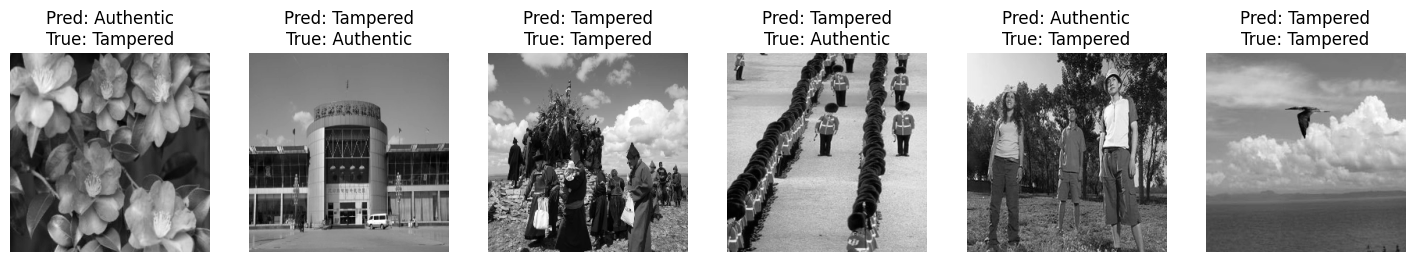

In [34]:
visualize_predictions()